In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import tensorflow as tf
import os


In [2]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
model_path = os.path.join(parent_dir, 'models', "model_enhanced_res_unet_2.keras")

In [3]:
# Load the model
model = tf.keras.models.load_model(model_path)

In [4]:
# Define the image path
path = 'C:/users/wfaiz/Data_Science/PCB_Defect/data_full/Images/'


In [5]:
# Loading and cropping image as per model input dimensions
def loading_image(path, image, crop_size):
    image_path = os.path.join(path, image)
    image_test = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  
    image_test = cv2.resize(image_test, (600, 600))  

    # Split the image into 100x100
    
    crops = []
    for i in range(0, 600, crop_size):
        for j in range(0, 600, crop_size):
            crop = image_test[i:i+crop_size, j:j+crop_size]
            crop = np.asarray(crop, dtype=np.float32) / 255.0  # Normalize
            crop = np.expand_dims(crop, axis=-1)  # Add channel dimension
            crops.append(crop)
    return image_test, crops

In [6]:
for layer in model.layers:
    print(layer.name)

# Evaluate which target layer to focus on. Choosing convolution layers closer to segmentation output.

input_layer_20
conv2d_280
batch_normalization_300
conv2d_281
conv2d_282
batch_normalization_301
batch_normalization_302
add_80
max_pooling2d_40
conv2d_283
batch_normalization_303
conv2d_284
conv2d_285
batch_normalization_304
batch_normalization_305
add_81
max_pooling2d_41
depthwise_conv2d_20
batch_normalization_306
conv2d_286
batch_normalization_307
conv2d_287
batch_normalization_308
conv2d_transpose_40
concatenate_40
conv2d_288
batch_normalization_309
conv2d_289
conv2d_290
batch_normalization_310
batch_normalization_311
add_82
conv2d_transpose_41
concatenate_41
conv2d_291
global_average_pooling2d_20
batch_normalization_312
dense_40
conv2d_292
conv2d_293
dropout_40
batch_normalization_313
batch_normalization_314
dense_41
add_83
dropout_41
segmentation_output
classification_output


In [7]:
img = "l_light_11_spur_02_5_600.jpg"

In [8]:
crop_size = 100
image, crops = loading_image(path, img, crop_size)

In [9]:
def implement_gradcam(target_layer, model, crops):
    
    # Get the target layer output
    target_layer_output = model.get_layer(target_layer).output

    # Flatten the list of output tensors from the model
    model_outputs = model.output if isinstance(model.output, list) else [model.output]

    # Create a new model for gradcam evaluation
    modified_model = tf.keras.Model(inputs=model.input, outputs=[target_layer_output] + model_outputs)

    # Prepare to store heatmaps for cropped 100x100 images
    heatmaps = []

    # Process each crop individually
    for crop in crops:
        crop_tensor = tf.convert_to_tensor(crop)
        crop_tensor = tf.expand_dims(crop_tensor, axis=0)
        with tf.GradientTape() as tape:
            tape.watch(crop_tensor)
            conv_outputs, *predictions = modified_model(crop_tensor)
            loss = predictions[0] if len(predictions) == 1 else [pred for pred in predictions]
            grads = tape.gradient(loss, conv_outputs)

        # Combine gradients with the output feature maps
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        pooled_grads = tf.reshape(pooled_grads, [1, 1, -1])  
        conv_output_value = conv_outputs[0]
        weighted_conv_outputs = conv_output_value * pooled_grads

        # Visualize the attention heatmap
        heatmap = tf.reduce_mean(weighted_conv_outputs, axis=-1)
        heatmap = tf.maximum(heatmap, 0)
        heatmap = heatmap / tf.reduce_max(heatmap)

        heatmaps.append(heatmap.numpy())

    return heatmaps

In [15]:
# define which layer to set as target for observation
target_layer = 'conv2d_292'

# call implement_gradcam to record observations
heatmaps = implement_gradcam(target_layer, model, crops)

In [ ]:
'''
for idx, crop in enumerate(crops):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(crop, cmap='gray')
    axs[0].set_title('Original cropped Image')
    axs[0].axis('off')

    axs[1].imshow(heatmaps[idx], cmap='hot')
    axs[1].set_title('Attention Heatmap')
    axs[1].axis('off')

    plt.show()
'''

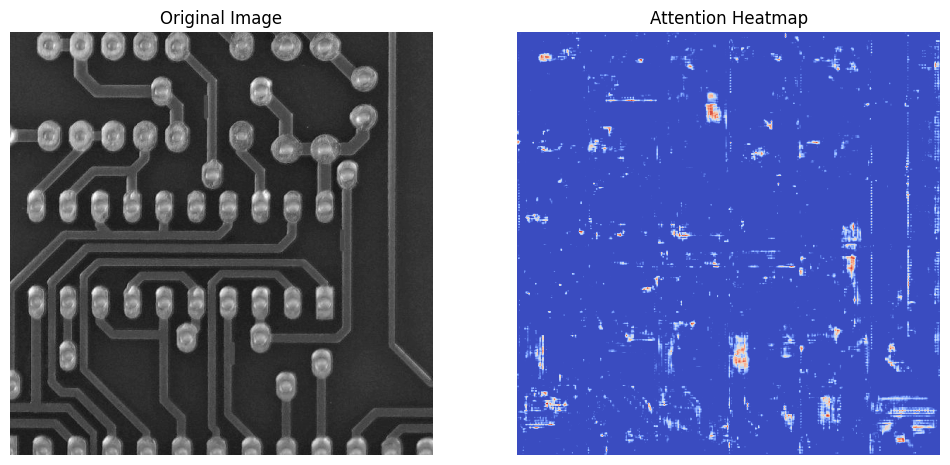

In [17]:

combined_heatmap = np.zeros((600, 600))
index = 0
for i in range(0, 600, crop_size):
    for j in range(0, 600, crop_size):
        combined_heatmap[i:i + crop_size, j:j + crop_size] = heatmaps[index]
        index += 1

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(combined_heatmap, cmap='coolwarm')
axs[1].set_title('Attention Heatmap')
axs[1].axis('off')

plt.show()

In [ ]:
# rotation_90_light_07_mouse_bite_03_4_600.jpg
